#DATASCI W261, Machine Learning at Scale
--------
####Assignement:  week \#7
####[Lei Yang](mailto:leiyang@berkeley.edu) | [Michael Kennedy](mailto:mkennedy@ischool.berkeley.edu) | [Natarajan Krishnaswami](mailto:natarajan@krishnaswami.org)
####Due: 2016-03-10, 8AM PST

###General Description
In this assignment you will explore networks and develop MRJob code for 
finding shortest path graph distances. To build up to large data 
you will develop your code on some very simple, toy networks.
After this you will take your developed code forward and modify it and 
apply it to two larger datasets (performing EDA along the way).


####Undirected toy network dataset

In an undirected network all links are symmetric, 
i.e., for a pair of nodes 'A' and 'B,' both of the links:

A -> B and B -> A

will exist. 

The toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/undirected_toy.txt

On under the Data Subfolder for HW7 on Dropbox with the same file name

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).


####Directed toy network dataset

In a directed network all links are not necessarily symmetric, 
i.e., for a pair of nodes 'A' and 'B,' it is possible for only one of:

A -> B or B -> A

to exist. 

These toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/directed_toy.txt

On under the Data Subfolder for HW7 on Dropbox with the same file name

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).


###HW 7.0: Shortest path graph distances (toy networks)

In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, 
as described in the lectures. In addition to finding the distances, 
your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use 
both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4

Solution: 1,5,4 

- shortest path in the directed network from node 1 to node 5

Solution: 1,2,4,5

and report your output---make sure it is correct!

###One Iteration BFS Mrjob
<img src="ShortestPathMapReduce.png" alt="Drawing" style="width: 550px;"/>

In [89]:
%%writefile ShortestPathIter.py
from mrjob.job import MRJob
from mrjob.step import MRStep


class ShortestPathIter(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(ShortestPathIter, self).__init__(*args, **kwargs)
        
                                                 
    def configure_options(self):
        super(ShortestPathIter, self).configure_options()
        self.add_passthrough_option(
            '--source', dest='source', default='1', type='string',
            help='source: source node (default 1)')        

    def mapper(self, _, line):
        nid, dic = line.strip().split('\t', 1)
        cmd = 'node = %s' %dic
        exec cmd        
        # if the node structure is incomplete (first pass), add them                
        if 'dist' not in node:            
            node = {'adj':node, 'path':[]}            
            node['dist'] = 0 if self.options.source==nid else -1            
        # emit node
        yield nid, node        
        # emit distances to reachable nodes
        if node['dist'] >= 0:
            for m in node['adj']:                
                ##### for regular weighted dataset
                #yield m, {'dd':node['adj'][m] + node['dist'], 'pp':node['path']+[nid]}
                ##### for wikipedia dataset, no weight
                yield m, {'dd':1 + node['dist'], 'pp':node['path']+[nid]}
                
    def reducer(self, nid, value):
        dmin = float('inf')
        path = node = None
        # loop through all arrivals
        for v in value:            
            if 'dist' in v:
                node = v
            elif v['dd'] < dmin:
                dmin = v['dd']
                path = v['pp']
        # handle dangling node
        if not node:
            node = {'adj':{}, 'dist':dmin, 'path':path}
        # update distance and path
        if (node['dist'] == -1 and path) or dmin < node['dist']:
            node['dist'] = dmin
            node['path'] = path
        # emit for next iteration
        yield nid, node
        
    def steps(self):
        jc = {
            'mapreduce.job.maps': '10',
            'mapreduce.job.reduces': '10',
        }
        return [MRStep(mapper=self.mapper
                       , combiner=self.reducer
                       , reducer=self.reducer
                       #, reducer_final=self.reducer_final
                       #, jobconf = jc
                      )
               ]

if __name__ == '__main__':
    ShortestPathIter.run()

Overwriting ShortestPathIter.py


In [79]:
##### unit test #####
#!python ShortestPathIter.py undirected_toy.txt --source 1 -r 'inline'

###Driver Program
- init_job: take raw import, do first level traverse, output intermediate graph file
- iter_job: iteratively traverse the graph and update the shortest distance and path

In [2]:
%%writefile RunBFS.py
#!/usr/bin/python
#%load_ext autoreload
#%autoreload 2
from ShortestPathIter import ShortestPathIter
import sys, getopt

# parse parameter
if __name__ == "__main__":
    
    try:
        opts, args = getopt.getopt(sys.argv[1:], "hg:s:d:m:")
    except getopt.GetoptError:
        print 'RunBFS.py -g <graph> -s <source> -d <destination> -m <mode>'
        sys.exit(2)
    if len(opts) != 4:
        print 'RunBFS.py -g <graph> -s <source> -d <destination> -m <mode>'
        sys.exit(2)
    for opt, arg in opts:
        if opt == '-h':
            print 'RunBFS.py -g <graph> -s <source> -d <destination> -m <mode>'
            sys.exit(2)
        elif opt == '-g':
            graph = arg
        elif opt == '-s':
            source = arg
        elif opt == '-d':
            destination = arg
        elif opt == '-m':
            mode = arg
        

# creat BFS job
init_job = ShortestPathIter(args=[graph, '--source', source, '-r', mode])
iter_job = ShortestPathIter(args=['graph', '--source', source, '-r', mode])

# run initialization job
with init_job.make_runner() as runner:
    runner.run()
    dist_old = {}
    # save our graph file for iteration
    with open('graph', 'w') as f:
        for line in runner.stream_output():
            # value is nid and node object
            nid, node = init_job.parse_output_line(line)
            # record distance for each node
            dist_old[nid] = node['dist']
            # write graph file 
            f.write('%s\t%s\n' %(nid, node))

# run BFS iteratively
i = 1
while(1):    
    print 'iteration %s' %i
    dist = {}
    with iter_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output    
        with open('graph', 'w') as f:
            for line in runner.stream_output():
                # value is nid and node object
                nid, node = iter_job.parse_output_line(line)
                dist[nid] = node['dist']
                f.write('%s\t%s\n' %(nid, str(node)))
            
    # check if distance for each node changes
    stop = True
    for n in dist:
        if dist_old[n] != dist[n]:
            stop = False
            break  
    
    if stop:
        break
    
    # save dist for next iteration comparison
    dist_old = dist
    i += 1
        
print "Traversing completes!\n"

# show path between source and destination
with open('graph', 'r') as f:
    line = f.readline()
    while (line):
        nid, node = line.split('\t')
        if nid == destination:
            cmd = 'node = %s' %node
            exec cmd
            if node['path']:
                print 'shortest distance between %s and %s: %s' %(source, destination, node['dist'])
                print 'path: %s' %' -> '.join(node['path']+[destination])
            else:
                print '%s is a dangling node, cannot traverse from it!' %source
            break
        line = f.readline()


Overwriting RunBFS.py


###Evaluation

In [91]:
!echo 'The shortest path in the undirected network from node 1 to node 4:'
!python RunBFS.py -s 1 -d 4 -m 'inline' -g undirected_toy.txt

!echo '\nThe shortest path in the directed network from node 1 to node 5:'
!python RunBFS.py -s 1 -d 5 -m 'inline' -g directed_toy.txt


The shortest path in the undirected network from node 1 to node 4:
iteration 1
iteration 2
Traversing completes!

shortest distance between 1 and 4: 2
path: 1 -> 2 -> 4

The shortest path in the directed network from node 1 to node 5:
iteration 1
iteration 2
iteration 3
Traversing completes!

shortest distance between 1 and 5: 3
path: 1 -> 2 -> 4 -> 5


###Main dataset 1: NLTK synonyms

- In the next part of this assignment you will explore a network derived from
the NLTK synonym database used for evaluation in HW 5. 
- At a high level, this network is undirected, defined so that there exists link between two nodes/words 
if the pair or words are a synonym. 

These data may be found at the location:

- s3://ucb-mids-mls-networks/synNet/synNet.txt
- s3://ucb-mids-mls-networks/synNet/indices.txt

On under the Data Subfolder for HW7 on Dropbox with the same file names

where synNet.txt contains a sparse representation of the network:

(index) \t (dictionary of links)

in indexed form, and indices.txt contains a lookup list

(word) \t (index)

of indices and words. This network is small enough for you to explore and run
scripts locally, but will also be good for a systems test (for later) on AWS.

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

###HW 7.1: Exploratory data analysis (NLTK synonyms)

Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?),
and determine some of the key features, like:

- number of nodes, 
- number links,
- or the average degree (i.e., the average number of links per node),
- etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

###MrJob to scan the graph

In [80]:
%%writefile ExploreGraph.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class ExploreGraph(MRJob):
    
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(ExploreGraph, self).__init__(*args, **kwargs)
        
                                                 
    def configure_options(self):
        super(ExploreGraph, self).configure_options()
        self.add_passthrough_option(
            '--source', dest='source', default='1', type='string',
            help='source: source node (default 1)')        

    def mapper(self, _, line):
        nid, dic = line.strip().split('\t', 1)
        cmd = 'adj = %s' %dic
        exec cmd        
        # let's emit the node degree as key, this way we can do some aggregation
        # value: number of nodes
        yield len(adj), 1
                        
    def combiner(self, degree, cnt):
        yield degree, sum(cnt)
        
    def reducer_init(self):
        self.degree_cnt = {}
        
    def reducer(self, degree, cnt):
        if degree not in self.degree_cnt:
            self.degree_cnt[degree] = sum(cnt)
        else:
            self.degree_cnt[degree] += sum(cnt)
            
    def reducer_final(self):
        # final aggregation
        tot_node = sum(self.degree_cnt.values())
        tot_degree = sum([d*self.degree_cnt[d] for d in self.degree_cnt])
        yield 'total nodes: ', tot_node
        yield 'total links: ', tot_degree/2
        yield 'average degree: ', 1.0*tot_degree/tot_node
        yield 'degree counts: ', self.degree_cnt        
        
    def steps(self):
        jc = {
            'mapreduce.job.maps': '10',
            'mapreduce.job.reduces': '1',
        }
        return [MRStep(mapper=self.mapper
                       , combiner=self.combiner
                       , reducer_init=self.reducer_init
                       , reducer=self.reducer                       
                       , reducer_final=self.reducer_final
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    ExploreGraph.run()

Overwriting ExploreGraph.py


###Explore NLTK Synonyms Net

In [44]:
!python ExploreGraph.py randNet.txt -r 'inline' > sumstats
!echo '\nSummary stats of the graph:'
!cat sumstats

using configs in /Users/leiyang/.mrjob.conf
creating tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/ExploreGraph.leiyang.20160228.174326.119530
Detected hadoop configuration property names that do not match hadoop version 0.20:
The have been translated as follows
 mapreduce.job.maps: mapred.map.tasks
mapreduce.job.reduces: mapred.reduce.tasks
Detected hadoop configuration property names that do not match hadoop version 0.20:
The have been translated as follows
 mapreduce.job.maps: mapred.map.tasks
mapreduce.job.reduces: mapred.reduce.tasks
Detected hadoop configuration property names that do not match hadoop version 0.20:
The have been translated as follows
 mapreduce.job.maps: mapred.map.tasks
mapreduce.job.reduces: mapred.reduce.tasks
writing to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/ExploreGraph.leiyang.20160228.174326.119530/step-0-mapper_part-00000
Detected hadoop configuration property names that do not match hadoop version 0.20:
The have been translated

###Node degree distribution

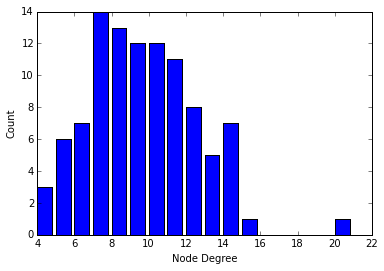

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
degrees = {"4": 3, "5": 6, "6": 7, "7": 14, "8": 13, "9": 12, "10": 12, "11": 11, "12": 8, "13": 5, "14": 7, "15": 1, "20": 1}
plt.bar([int(k) for k in degrees.keys()], degrees.values())
plt.xlabel('Node Degree')
plt.ylabel('Count')
plt.show()

###HW 7.2: Shortest path graph distances (NLTK synonyms)

Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset. 

Proof your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

In [49]:
##### execute RunBFS.py from HW 7.0 #####
!python RunBFS.py -g randNet.txt -d 34 -s 58 -m 'inline'

iteration 1
iteration 2
iteration 3
iteration 4
Traversing completes!

shortest distance between 58 and 34: 2
path: 58 -> 21 -> 34


###Main dataset 2: English Wikipedia

For the remainder of this assignment you will explore the English Wikipedia hyperlink network.
The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles: 

A -> B

is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

- s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt
- s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt
- s3://ucb-mids-mls-networks/wikipedia/indices.txt

On under the Data Subfolder for HW7 on Dropbox with the same file names

but has an index with more detailed data:

(article name) \t (index) \t (in degree) \t (out degree)

In the dictionary, target nodes are keys, link weights are values .
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.

###HW 7.3: Exploratory data analysis (Wikipedia)

Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 
Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 
This means that you may have to ADJUST your code (depending on its design). 
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.


In [76]:
!python ExploreGraph.py 's3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt' \
-r 'emr' --cleanup 'NONE' > wiki_sumstats

Got unexpected keyword arguments: ssh_tunnel
using configs in /Users/leiyang/.mrjob.conf
using existing scratch bucket mrjob-93087988ff77f80a
using s3://mrjob-93087988ff77f80a/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/ExploreGraph.leiyang.20160228.203032.281027
writing master bootstrap script to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/ExploreGraph.leiyang.20160228.203032.281027/b.py
Copying non-input files into s3://mrjob-93087988ff77f80a/tmp/ExploreGraph.leiyang.20160228.203032.281027/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-1XNAN68V7HLXZ
Created new job flow j-1XNAN68V7HLXZ
Detected hadoop configuration property names that do not match hadoop version 1.0.3:
The have been translated as follows
 mapreduce.job.maps: mapred.map.tasks
mapreduce.job.reduces: mapred.reduce.tasks
Job launched 90.7s ago, status STARTING: Provisioning Amazon EC2 capacity
J

"total nodes: "	5781290
"total links: "	71057028
"average degree: "	24.58172086160701


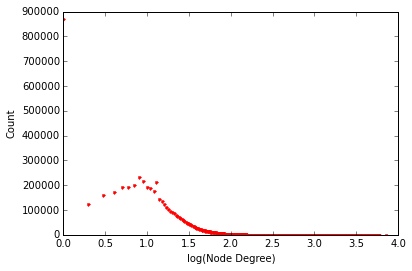

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import log10

with open('wiki_sumstats', 'r') as f:
    lines = f.readlines()
for line in lines:
    if 'degree counts' not in line:
        print line.strip()
    else:
        dc, dic = line.split('\t')
        cmd = 'degrees = %s' %dic
        exec cmd
        
plt.plot([log10(int(k)) for k in degrees.keys()], degrees.values(), 'r.')
plt.xlabel('log(Node Degree)')
plt.ylabel('Count')
plt.show()

###HW 7.4: Shortest path graph distances (Wikipedia)

Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output.

Once your code is running, find some other shortest paths and report your results.

###Two changes to improve performance for unweighted graph
- in iteration mrjob: no need to store weight value, to reduce the amount of data during processing
- in driver program: the stopping criterion for unweighted network is simpler: once the destination becomes frontier, it has the shortest path from the source

###Mrjob for unweighted BFS iteration

In [112]:
%%writefile UnweightedShortestPathIter.py
from mrjob.job import MRJob
from mrjob.step import MRStep


class UnweightedShortestPathIter(MRJob):
    DEFAULT_PROTOCOL = 'json'
    
    def __init__(self, *args, **kwargs):
        super(UnweightedShortestPathIter, self).__init__(*args, **kwargs)
        
                                                 
    def configure_options(self):
        super(UnweightedShortestPathIter, self).configure_options()
        self.add_passthrough_option(
            '--source', dest='source', default='1', type='string',
            help='source: source node (default 1)')        

    def mapper(self, _, line):
        nid, dic = line.strip().split('\t', 1)
        cmd = 'node = %s' %dic
        exec cmd        
        # if the node structure is incomplete (first pass), add them                
        if 'dist' not in node:            
            node = {'adj':node.keys(), 'path':[]}            
            node['dist'] = 0 if self.options.source==nid else -1            
        # emit node
        yield nid, node        
        # emit distances to reachable nodes
        if node['dist'] >= 0:
            for m in node['adj']:                                
                ##### for unweighted network #####
                yield m, {'dd':1 + node['dist'], 'pp':node['path']+[nid]}
                
    def reducer(self, nid, value):
        dmin = float('inf')
        path = node = None
        # loop through all arrivals
        for v in value:            
            if 'dist' in v:
                node = v
            elif v['dd'] < dmin:
                dmin = v['dd']
                path = v['pp']
        # handle dangling node
        if not node:
            node = {'adj':[], 'dist':dmin, 'path':path}
        # update distance and path
        if (node['dist'] == -1 and path) or dmin < node['dist']:
            node['dist'] = dmin
            node['path'] = path
        # emit for next iteration
        yield nid, node
        
    def steps(self):
        jc = {
            'mapreduce.job.maps': '10',
            'mapreduce.job.reduces': '10',
        }
        return [MRStep(mapper=self.mapper
                       , combiner=self.reducer
                       , reducer=self.reducer                       
                       , jobconf = jc
                      )
               ]

if __name__ == '__main__':
    UnweightedShortestPathIter.run()

Overwriting UnweightedShortestPathIter.py


###Unit test for unweighted BFS iteration

In [ ]:
#!python UnweightedShortestPathIter.py 's3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt' --source 6176135 -r 'emr' --cleanup 'NONE'

#python UnweightedShortestPathIter.py all*out.txt --source 6176135 --cleanup 'NONE' -r 'inline'

###Driver program for unweighted BFS

In [99]:
%%writefile RunUnweightedBFS.py
#!/usr/bin/python
#%load_ext autoreload
#%autoreload 2
from UnweightedShortestPathIter import UnweightedShortestPathIter
import sys, getopt

# parse parameter
if __name__ == "__main__":
    
    try:
        opts, args = getopt.getopt(sys.argv[1:], "hg:s:d:m:")
    except getopt.GetoptError:
        print 'RunBFS.py -g <graph> -s <source> -d <destination> -m <mode>'
        sys.exit(2)
    if len(opts) != 4:
        print 'RunBFS.py -g <graph> -s <source> -d <destination> -m <mode>'
        sys.exit(2)
    for opt, arg in opts:
        if opt == '-h':
            print 'RunBFS.py -g <graph> -s <source> -d <destination> -m <mode>'
            sys.exit(2)
        elif opt == '-g':
            graph = arg
        elif opt == '-s':
            source = arg
        elif opt == '-d':
            destination = arg
        elif opt == '-m':
            mode = arg
        

# creat BFS job
init_job = UnweightedShortestPathIter(args=[graph, '--source', source, '-r', mode])
iter_job = UnweightedShortestPathIter(args=['graph', '--source', source, '-r', mode])

# run initialization job
with init_job.make_runner() as runner:
    runner.run()    
    # save our graph file for iteration
    with open('graph', 'w') as f:
        for line in runner.stream_output():
            # value is nid and node object
            nid, node = init_job.parse_output_line(line)            
            # write graph file 
            f.write('%s\t%s\n' %(nid, node))

# run BFS iteratively

i = 1
while(1):    
    print 'iteration %s' %i    
    stop = False
    with iter_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output    
        with open('graph', 'w') as f:
            for line in runner.stream_output():
                # value is nid and node object
                nid, node = iter_job.parse_output_line(line)                
                f.write('%s\t%s\n' %(nid, str(node)))
                if nid == destination and node['dist'] > 0:
                    stop = True
                    break
    
    if stop:
        break
    # more iteration needed
    i += 1
        
print "Traversing completes!\n"

# show path between source and destination
with open('graph', 'r') as f:
    line = f.readline()
    while (line):
        nid, node = line.split('\t')
        if nid == destination:
            cmd = 'node = %s' %node
            exec cmd
            if node['path']:
                print 'shortest distance between %s and %s: %s' %(source, destination, node['dist'])
                print 'path: %s' %' -> '.join(node['path']+[destination])
            else:
                print '%s is a dangling node, cannot traverse from it!' %source
            break
        line = f.readline()


Overwriting RunUnweightedBFS.py


###Unit test of unweighted BFS

In [110]:
!python RunUnweightedBFS.py -s 1 -d 4 -m 'inline' -g undirected_toy.txt

iteration 1
Traversing completes!

shortest distance between 1 and 4: 2
path: 1 -> 2 -> 4


###wikipedia dataset

In [94]:
%%writefile FindWikiShortestPath.sh
#!/usr/bin/python

python RunUnweightedBFS.py -s '6176135' -d '13466359' -m 'emr' -g 's3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt'

Overwriting FindWikiShortestPath.sh


###HW 7.5: Conceptual exercise: Largest single-source network distances

Suppose you wanted to find the largest network distance from a single source,
i.e., a node that is the furthest (but still reachable) from a single source.

How would you implement this task? 
How is this different from finding the shortest path graph distances?

Is this task more difficult to implement than the shortest path distance?

As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...

###Answer:
- change the distance comparison step, instead of keeping smaller distance, choose larger distance here

###HW 7.6 (optional): Computational exercise: Largest single-source network distances 

Using MRJob, write a code to find the largest graph distance and distance-maximizing nodes from a single-source.
Test your code first on the toy networks and synonyms network to proof its function.

###stop yarn, hdfs, and job history

In [245]:
!/usr/local/Cellar/hadoop/2*/sbin/stop-yarn.sh
!/usr/local/Cellar/hadoop/2*/sbin/stop-dfs.sh
!/usr/local/Cellar/hadoop/2*/sbin/mr-jobhistory-daemon.sh --config /usr/local/Cellar/hadoop/2*/libexec/etc/hadoop/ stop historyserver 

stopping yarn daemons
stopping resourcemanager
localhost: stopping nodemanager
localhost: nodemanager did not stop gracefully after 5 seconds: killing with kill -9
no proxyserver to stop
Stopping namenodes on [localhost]
localhost: stopping namenode
localhost: stopping datanode
Stopping secondary namenodes [0.0.0.0]
0.0.0.0: stopping secondarynamenode
stopping historyserver


###start yarn, hdfs, and job history

In [10]:
!/usr/local/Cellar/hadoop/2*/sbin/start-yarn.sh
!/usr/local/Cellar/hadoop/2*/sbin/start-dfs.sh
!/usr/local/Cellar/hadoop/2*/sbin/mr-jobhistory-daemon.sh --config /usr/local/Cellar/hadoop/2*/libexec/etc/hadoop/ start historyserver 

starting yarn daemons
starting resourcemanager, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/yarn-leiyang-resourcemanager-Leis-MacBook-Pro.local.out
localhost: starting nodemanager, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/yarn-leiyang-nodemanager-Leis-MacBook-Pro.local.out
Starting namenodes on [localhost]
localhost: starting namenode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-leiyang-namenode-Leis-MacBook-Pro.local.out
localhost: starting datanode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-leiyang-datanode-Leis-MacBook-Pro.local.out
Starting secondary namenodes [0.0.0.0]
0.0.0.0: starting secondarynamenode, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/hadoop-leiyang-secondarynamenode-Leis-MacBook-Pro.local.out
starting historyserver, logging to /usr/local/Cellar/hadoop/2.7.1/libexec/logs/mapred-leiyang-historyserver-Leis-MacBook-Pro.local.out
16/02/26 17:44:11 INFO hs.JobHistoryServer: STARTUP_MSG: 
/**********